# Modeling Notebook

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

In [2]:
# import dataset
df = pd.read_csv('..\\data\\telecom_data.csv')

# Handle object types for international plan and voice mail plan
df.loc[df['international plan'] == 'no', 'international plan'] = 0
df.loc[df['international plan'] == 'yes', 'international plan'] = 1 

df.loc[df['voice mail plan'] == 'no', 'voice mail plan'] = 0
df.loc[df['voice mail plan']== 'yes', 'voice mail plan'] = 1

# Change churn to values: 1 (churned/True) 0 (no churn/False)
df.loc[df['churn'] == True, 'churn'] = 1
df.loc[df['churn'] == False, 'churn'] = 0

# going to create backup df and drop phone number from original df
# phone number could be used as unique id, but it doesn't seem necessary
df_backup = df.copy()
df = df.drop(['phone number'], axis=1)

# casting int values to churn, voice mail plan, and international plan cols
objs = ['international plan', 'voice mail plan', 'churn']

for o in objs:
    df = df.astype({o: int})
    
# dropping area code
df = df.drop(['area code'], axis=1)

# check df
df.head()

,state,account length,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


Handle international calls to bin them into categories easier.

In [3]:
# handle international calls to bin them into categories easier.
df['total intl calls'].value_counts()

3     668
4     619
2     489
5     472
6     336
7     218
1     160
8     116
9     109
10     50
11     28
0      18
12     15
13     14
15      7
14      6
18      3
16      2
19      1
17      1
20      1
Name: total intl calls, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x26dae85aee0>,
 'caps': [<matplotlib.lines.Line2D at 0x26dae8725e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x26dae85ab80>],
 'medians': [<matplotlib.lines.Line2D at 0x26dae872ca0>],
 'fliers': [<matplotlib.lines.Line2D at 0x26dae87d040>],
 'means': []}

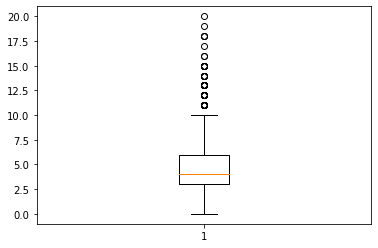

In [4]:
plt.boxplot(df['total intl calls'])

In [5]:
df['total intl calls'].describe()

count    3333.000000
mean        4.479448
std         2.461214
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max        20.000000
Name: total intl calls, dtype: float64

In [6]:
# range is 0-20 for international calls with most concentrated from 0-10
# I will bin into cats: low, moderate, and high with values <3, 3-6, and >6

list_tmp = []

for index, row in df.iterrows():
    if row['total intl calls'] < 3:
        list_tmp.append('low')
    elif row['total intl calls'] > 6:
        list_tmp.append('high')
    else:
        list_tmp.append('moderate')

df['total_intl_calls'] = list_tmp

df['total_intl_calls'].describe()

count         3333
unique           3
top       moderate
freq          2095
Name: total_intl_calls, dtype: object

What would be the % chance of guessing correctly if the customer was assumed to not churn?

In [7]:
1-df.churn.mean()

0.8550855085508551

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   international plan      3333 non-null   int32  
 3   voice mail plan         3333 non-null   int32  
 4   number vmail messages   3333 non-null   int64  
 5   total day minutes       3333 non-null   float64
 6   total day calls         3333 non-null   int64  
 7   total day charge        3333 non-null   float64
 8   total eve minutes       3333 non-null   float64
 9   total eve calls         3333 non-null   int64  
 10  total eve charge        3333 non-null   float64
 11  total night minutes     3333 non-null   float64
 12  total night calls       3333 non-null   int64  
 13  total night charge      3333 non-null   float64
 14  total intl minutes      3333 non-null   

Handle state and total_intl_calls object types. Turn these into integers for later modeling.

In [9]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA",
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA",
          "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY",
          "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX",
          "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [10]:
state_int = []
for i, row in df.iterrows():
    state_int.append(states.index(row['state']))

In [11]:
df['state_int'] = state_int

In [12]:
intl_calls_int = []
for i, row in df.iterrows():
    if row['total_intl_calls'] == 'low':
        intl_calls_int.append(0)
    elif row['total_intl_calls'] == 'moderate':
        intl_calls_int.append(1)
    else:
        intl_calls_int.append(2)

df['intl_calls_bins'] = intl_calls_int

In [13]:
cats = ['state_int', 'international plan', 'intl_calls_bins',
        'customer service calls', 'voice mail plan']

# Baseline Model

In [14]:
y = df['churn']
# dropping # vmail messages because its distribution isn't normal
X = df.drop(['churn', 'total intl calls', 'number vmail messages',
             'total_intl_calls', 'state'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [15]:
# Fixing class imbalance with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

In [16]:
X_train_cats = X_train_resampled[cats]
X_train_cats

,state_int,international plan,intl_calls_bins,customer service calls,voice mail plan
0,19,0,1,1,0
1,44,0,1,0,0
2,31,0,1,2,0
3,44,1,1,2,0
4,8,0,1,3,0
...,...,...,...,...,...
4271,3,0,1,5,0
4272,15,0,0,2,0
4273,36,1,0,0,0
4274,40,0,1,0,0


In [17]:
# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_train_cats)
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_cats),
    index=X_train_cats.index,
    columns=np.hstack(ohe.categories_)
)
X_train_ohe

,0,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,8,9,0,1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
X_train_numerics = X_train_resampled.drop(cats, axis=1)
X_train_numerics

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl charge
0,66,207.700000,85,35.310000,196.700000,112,16.720000,261.700000,83,11.780000,6.800000,1.840000
1,81,129.900000,121,22.080000,230.100000,105,19.560000,140.500000,123,6.320000,13.300000,3.590000
2,16,144.800000,84,24.620000,164.900000,141,14.020000,231.500000,75,10.420000,8.200000,2.210000
3,61,78.200000,103,13.290000,195.900000,149,16.650000,108.000000,100,4.860000,10.100000,2.730000
4,136,101.700000,105,17.290000,202.800000,99,17.240000,136.200000,119,6.130000,9.400000,2.540000
...,...,...,...,...,...,...,...,...,...,...,...,...
4271,80,153.537135,82,26.099027,196.961173,88,16.743200,229.125227,88,10.312706,9.528753,2.574334
4272,115,229.106692,101,38.950218,275.169559,60,23.391051,214.660981,82,9.657025,12.115270,3.270203
4273,147,229.011989,97,38.932172,186.185972,85,15.825633,133.601137,123,6.008281,9.762217,2.633258
4274,130,211.307432,101,35.925955,188.888609,135,16.052510,169.153386,104,7.607733,10.740891,2.898305


In [19]:
# Scaling variables to work well with OHE data

scaler = MinMaxScaler()

scaler.fit(X_train_numerics)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numerics),
    index=X_train_numerics.index,
    columns=X_train_numerics.columns
)
X_train_scaled

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl charge
0,0.268595,0.592075,0.515152,0.592052,0.500605,0.632911,0.500712,0.641474,0.352113,0.641961,0.340000,0.340741
1,0.330579,0.370296,0.733333,0.370221,0.601633,0.588608,0.601779,0.315492,0.633803,0.315601,0.665000,0.664815
2,0.061983,0.412771,0.509091,0.412810,0.404416,0.816456,0.404626,0.560247,0.295775,0.560669,0.410000,0.409259
3,0.247934,0.222919,0.624242,0.222837,0.498185,0.867089,0.498221,0.228080,0.471831,0.228332,0.505000,0.505556
4,0.557851,0.289909,0.636364,0.289906,0.519056,0.550633,0.519217,0.303927,0.605634,0.304244,0.470000,0.470370
...,...,...,...,...,...,...,...,...,...,...,...,...
4271,0.326446,0.437677,0.496970,0.437609,0.501395,0.481013,0.501537,0.553860,0.387324,0.554256,0.476438,0.476729
4272,0.471074,0.653098,0.612121,0.653089,0.737960,0.303797,0.738116,0.514957,0.345070,0.515064,0.605764,0.605593
4273,0.603306,0.652828,0.587879,0.652786,0.468802,0.462025,0.468884,0.296937,0.633803,0.296968,0.488111,0.487640
4274,0.533058,0.602359,0.612121,0.602380,0.476977,0.778481,0.476958,0.392559,0.500000,0.392572,0.537045,0.536723


In [20]:
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis=1)
X_train_full

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,...,2,3,4,5,6,7,8,9,0,1
0,0.268595,0.592075,0.515152,0.592052,0.500605,0.632911,0.500712,0.641474,0.352113,0.641961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.330579,0.370296,0.733333,0.370221,0.601633,0.588608,0.601779,0.315492,0.633803,0.315601,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.061983,0.412771,0.509091,0.412810,0.404416,0.816456,0.404626,0.560247,0.295775,0.560669,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.247934,0.222919,0.624242,0.222837,0.498185,0.867089,0.498221,0.228080,0.471831,0.228332,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.557851,0.289909,0.636364,0.289906,0.519056,0.550633,0.519217,0.303927,0.605634,0.304244,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,0.326446,0.437677,0.496970,0.437609,0.501395,0.481013,0.501537,0.553860,0.387324,0.554256,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4272,0.471074,0.653098,0.612121,0.653089,0.737960,0.303797,0.738116,0.514957,0.345070,0.515064,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4273,0.603306,0.652828,0.587879,0.652786,0.468802,0.462025,0.468884,0.296937,0.633803,0.296968,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4274,0.533058,0.602359,0.612121,0.602380,0.476977,0.778481,0.476958,0.392559,0.500000,0.392572,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
# model
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train_full, y_train_resampled)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [22]:
# Model Evaluation
y_hat_train = logreg.predict(X_train_full)

train_residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(train_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(train_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    3422
1     854
Name: Residuals (counts), dtype: int64

0    0.800281
1    0.199719
Name: Residuals (proportions), dtype: float64


Train set is about 81% accurate.

In [23]:
# performance evaluation on test set.
X_test_cats = X_test[cats]

# handle categorical values
ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

ohe.fit(X_test_cats)
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_cats),
    index=X_test_cats.index,
    columns=np.hstack(ohe.categories_)
)

X_test_numerics = X_test.drop(cats, axis=1)

# Scaling variables to work well with OHE data

scaler = MinMaxScaler()

scaler.fit(X_test_numerics)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numerics),
    index=X_test_numerics.index,
    columns=X_test_numerics.columns
)

X_test_full = pd.concat([X_test_scaled, X_test_ohe], axis=1)
X_test_full

,account length,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,...,2,3,4,5,6,7,8,9,0,1
2360,0.290043,0.659357,0.560345,0.659364,0.548254,0.607143,0.548366,0.364639,0.557522,0.364785,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
600,0.437229,0.300391,0.405172,0.300353,0.676382,0.458333,0.676480,0.391711,0.849558,0.391530,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1501,0.307359,0.810454,0.396552,0.810424,0.296673,0.744048,0.296668,0.441845,0.327434,0.442051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1114,0.463203,0.488135,0.370690,0.488163,0.734122,0.553571,0.734390,0.659759,0.619469,0.659733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
517,0.220779,0.637128,0.224138,0.637102,0.436074,0.821429,0.436105,0.234291,0.619469,0.234027,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688,0.051948,0.940222,0.543103,0.940106,0.574374,0.422619,0.574571,0.691176,0.699115,0.690936,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
181,0.541126,0.167017,0.448276,0.166961,0.381358,0.702381,0.381430,0.279078,0.415929,0.279346,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1448,0.471861,0.720637,0.586207,0.720671,0.446247,0.833333,0.446457,0.437166,0.371681,0.436850,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2085,0.320346,0.408231,0.586207,0.408304,0.421226,0.511905,0.421223,0.542447,0.522124,0.542348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
y_hat_test = logreg.predict(X_test_full)

test_residuals = np.abs(y_test - y_hat_test)
print(pd.Series(test_residuals, name="Residuals (counts)").value_counts())
print()
print(pd.Series(test_residuals, name="Residuals (proportions)").value_counts(normalize=True))

0    604
1    230
Name: Residuals (counts), dtype: int64

0    0.724221
1    0.275779
Name: Residuals (proportions), dtype: float64


Test set is about 72% accurate.

# Model 2

In [47]:
# random forest model
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, max_depth= 5)
forest.fit(X_train_full, y_train_resampled)

RandomForestClassifier(max_depth=5)

In [48]:
# Training Accuracy
forest.score(X_train_full, y_train_resampled)

0.8327876520112254

In [49]:
# Testing Accuracy
forest.score(X_test_full, y_test)

0.8105515587529976

In [50]:
def plot_feature_importances(model):
    n_features = X_train_full.shape[1]
    plt.figure(figsize=(8,16))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train_full.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

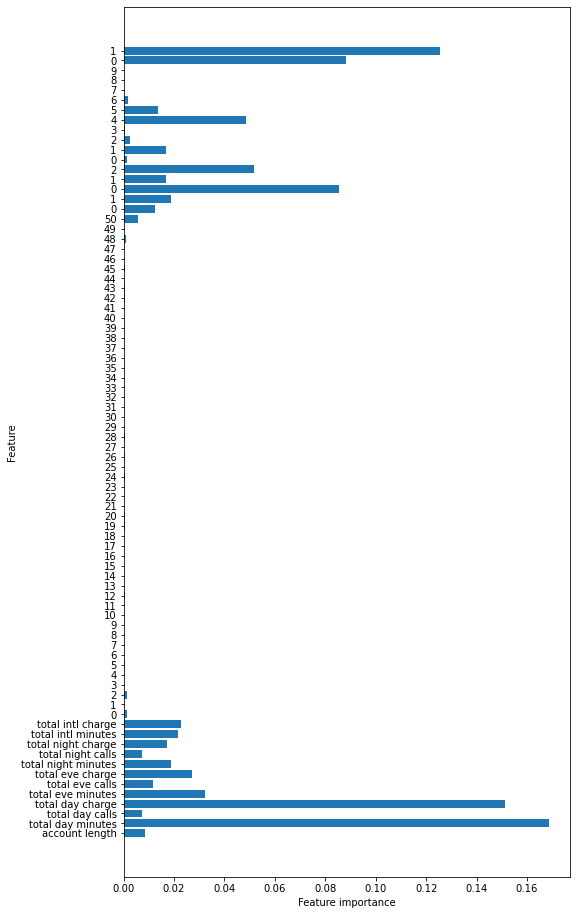

In [51]:
plot_feature_importances(forest)


# Model 3 - Pipelines